# MULTIPAC test bench example
This notebook showcases the basic utilisation of the library.

## Set up
First of all, load some useful libraries.

In [1]:
from pathlib import Path
import tomllib
from multipac_testbench.src.multipactor_test import MultipactorTest

Now we need to initialize our test bench representation as well as multipacting test data, as returned by LabVIEW.

In [2]:
project = Path("../data")
config_path = Path(project, "example_configuration.toml")
results_path = Path(project, "120MHz-SWR4-run1.csv")  # send email placais@lpsc.in2p3.fr to get the file

with open(config_path, "rb") as f:
    config = tomllib.load(f)

multipactor_test = MultipactorTest(results_path, config)

## Structure of the data
The object that we created has a ``pick_ups`` attribute, which is a list of the ``PickUp`` objects.

In [3]:
print(f"The pick-ups are: {multipactor_test.pick_ups}\n")

my_pick_up = multipactor_test.pick_ups[5]
print(f"The sixth pick-up is named {my_pick_up.name}.")

The pick-ups are: [<multipac_testbench.src.pick_up.PickUp object at 0x7fde25bdb3d0>, <multipac_testbench.src.pick_up.PickUp object at 0x7fde25bdb2d0>, <multipac_testbench.src.pick_up.PickUp object at 0x7fdea82cc610>, <multipac_testbench.src.pick_up.PickUp object at 0x7fde25ab5410>, <multipac_testbench.src.pick_up.PickUp object at 0x7fde25ab4f50>, <multipac_testbench.src.pick_up.PickUp object at 0x7fde25ab5ad0>, <multipac_testbench.src.pick_up.PickUp object at 0x7fde25ab5d90>]

The sixth pick-up is named E6.


Each ``PickUp`` has an attribute ``instruments``, holding its list of ``Instruments``.

In [4]:
instruments = my_pick_up.instruments
print(f"The instruments of this pick_up are: {instruments}\n")

print(f"The first of those is a {instruments[0].__class__.__name__}, and it measured:\n{instruments[0].raw_data}.")

The instruments of this pick_up are: [<multipac_testbench.src.instruments.current_probe.CurrentProbe object at 0x7fde25ab5ed0>, <multipac_testbench.src.instruments.e_field_probe.ElectricFieldProbe object at 0x7fde25ab6010>]

The first of those is a CurrentProbe, and it measured:
Sample index
1      7.50
2      7.83
3      8.49
4      9.14
5      8.49
       ... 
694    7.50
695    8.81
696    9.47
697    8.16
698    8.16
Name: NI9205_MP6l, Length: 698, dtype: float64.


## The user interface
Hopefully, there is easier ways to access and plot the data. To plot the raw signal measured from the electric field and current probes, run:

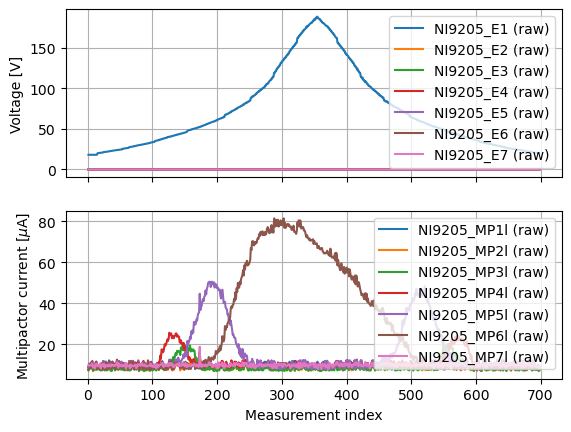

In [5]:
from multipac_testbench.src.instruments.current_probe import CurrentProbe
from multipac_testbench.src.instruments.e_field_probe import ElectricFieldProbe
instruments_to_plot = (ElectricFieldProbe, CurrentProbe)

multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    raw=True,  # we did not define any post-treatment, so raw=False would plot the same data
)

As one can see, the electric field measured at E1 is way too high. We can remove it from the plot by doing:

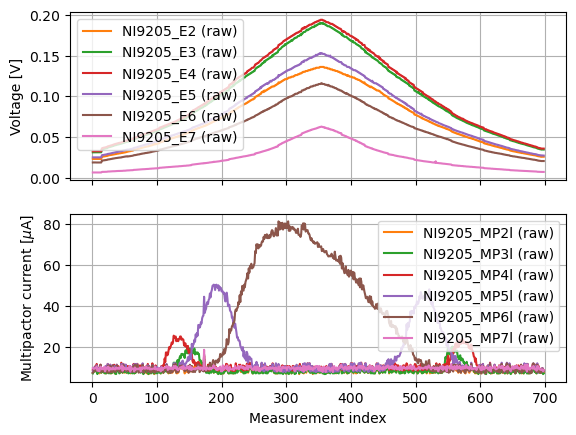

In [6]:
pick_up_to_exclude = ("E1", )

multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    raw=True
)

This is much better! Now we would like to smooth the current data. For that, we must define a function that takes in an array, and returns an array with the same shape.

In [7]:
from multipac_testbench.src.util.post_treaters import running_mean
from functools import partial
# partial allows us to set some function keywords arguments once and for all

current_smoother = partial(
    running_mean,  # the base function
    n_mean=10,     # to perform the running mean over 10 samples
    mode='same',   # for more info, go to the documentation
)

multipactor_test.add_post_treater(
    current_smoother,  # the smoothing function
    CurrentProbe,      # the instrument concerned by this post-treatment
)

Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.


The warnings are only here to say that the ``ydata`` attribute of every ``Instrument`` have been removed, and will be recomputed the first time access it.
Now we can plot the smoothed data:

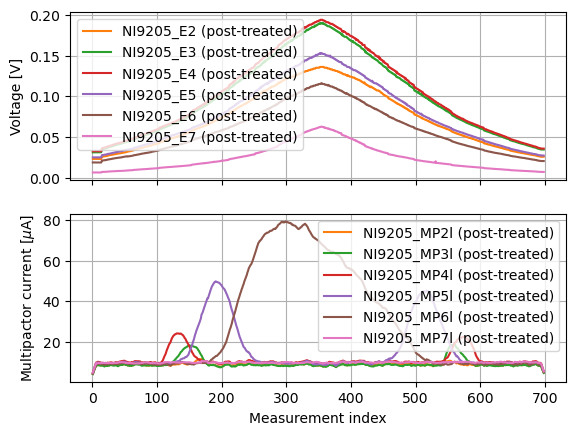

In [8]:
multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    raw=False,  # to plot the post-treated data
)

## Detecting multipator
We need to define a function that takes in the ``ydata`` of an ``Instrument``, and return an boolean array where ``False`` means no multipactor, ``True`` means multipactor.

In [9]:
from multipac_testbench.src.util.multipactor_detectors import quantity_is_above_threshold
# this simple function returns True when ydata crosses a threshold

# Define our multipactor criterions, that we will apply on the CurrentProbe
current_multipactor_criterions = {
    'threshold': 14., # current above which there is multipactor
    'consecutive_criterion': 10,  # multipactor zones separated by this number of measure points or less will be gathered
    'minimum_number_of_points': 3,  # multipactor zones measured on less than 3 consecutive points will not be considered as MP
}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)

multipactor_test.set_multipac_detector(current_multipac_detector,  # function that detects multipactor
                                       CurrentProbe)               # Instrument on which it is applied

As every type of ``Instrument`` has different sensitivity, each one can have its own multipactor criterion. You can also call the ``Instrument.set_multipactor_detector`` or ``Instrument.add_post_treater`` methods to treat a specific ``Instrument`` differently.

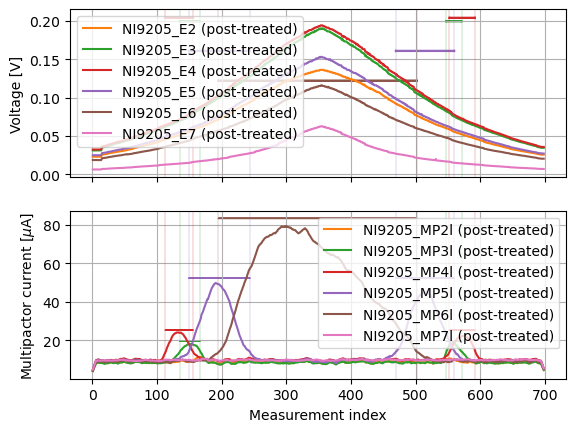

In [10]:
# We define that we want the multipactor zones calculated by the CurrentProbes on the ElectricFieldProbe and CurrentProbe plots.
multipactor_plots = {CurrentProbe: CurrentProbe,
                     ElectricFieldProbe: CurrentProbe,
                    }

# Also, we would like to save this plot, so we precise ``png_path``
png_path = results_path.with_suffix(".png")

multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    png_path=png_path,
    multipactor_plots=multipactor_plots,
    raw=False,
)

## Creating animations
A sweet feature is the creation of animations, to reproduce what was measured by each instrument with the time.

The animation will not appear in this notebook, you should go see it at ``gif_path``.

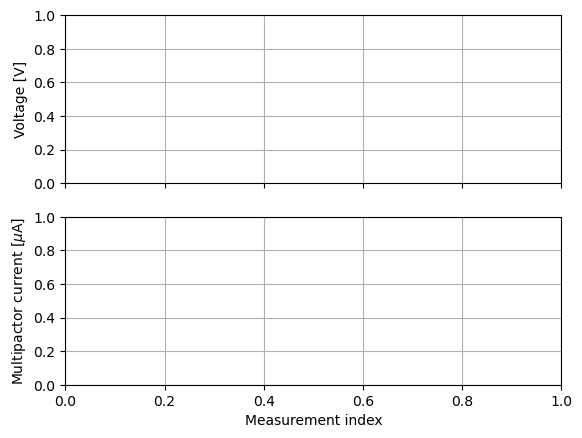

In [11]:
gif_path = results_path.with_suffix(".gif")

multipactor_test.animate_pick_ups(
    (ElectricFieldProbe, CurrentProbe),                 # the instruments to plot
    pick_ups_to_ignore_for_limits=pick_up_to_exclude,   # E1 will be plotted without modifying the limits
    gif_path=gif_path,                                  # providing this will create a .gif file 
    fps=100,                                            # frames per second
    keep_one_frame_over=50,                             # to keep only one image over 50
)